XGBoost is not installed. Skipping...
📊 Model Comparison Summary:
LinearRegression     → RMSE: 1.046, Correlation: 0.058
NNLS                 → RMSE: 1.075, Correlation: -0.033
RidgeRegression      → RMSE: 1.047, Correlation: -0.004
RandomForest         → RMSE: 1.044, Correlation: 0.090
GradientBoosting     → RMSE: 1.095, Correlation: 0.089
ExtraTrees           → RMSE: 1.323, Correlation: 0.062
SVR                  → RMSE: 1.054, Correlation: 0.051


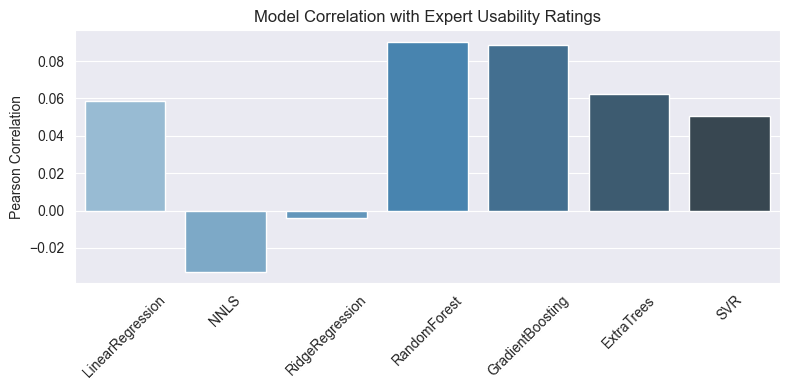

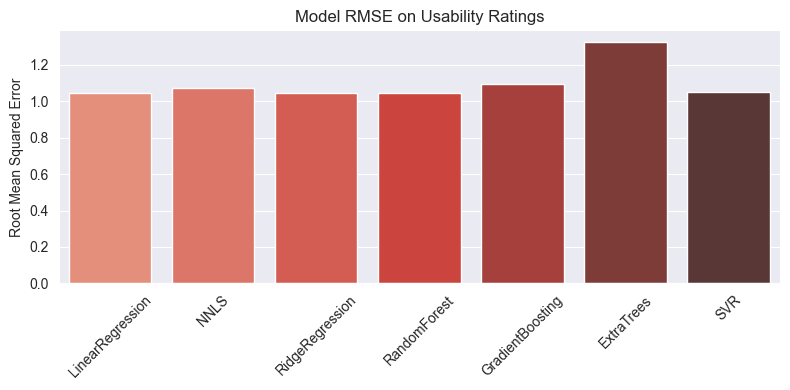

🧠 Random Forest Feature Importance:
entropy              0.287271
symmetry_score       0.180435
center_of_gravity    0.164436
visual_coverage      0.134352
clusters_score       0.121943
placement_score      0.111563
dtype: float64
🧠 Gradient Boosting Feature Importance:
entropy              0.229414
symmetry_score       0.186994
visual_coverage      0.184429
center_of_gravity    0.168848
placement_score      0.124460
clusters_score       0.105855
dtype: float64
🧠 Extra Trees Feature Importance:
entropy              0.192391
visual_coverage      0.168959
symmetry_score       0.166775
center_of_gravity    0.164265
placement_score      0.158392
clusters_score       0.149218
dtype: float64


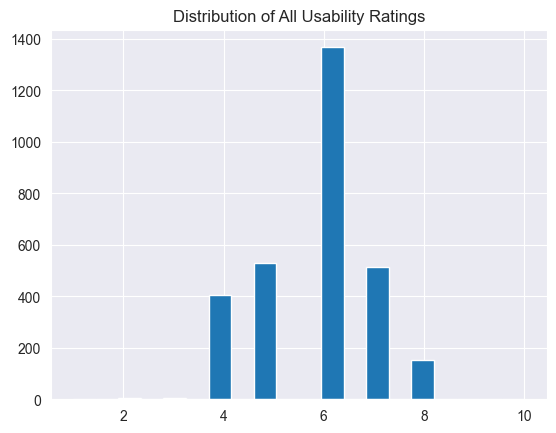

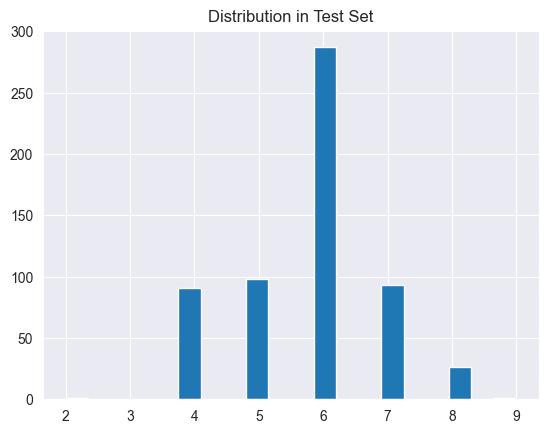

LinearRegression     CV RMSE: 1.066 ± 0.026
RandomForest         CV RMSE: 1.066 ± 0.021
GradientBoosting     CV RMSE: 1.096 ± 0.020


In [42]:
from sklearn.svm import SVR
# Usability Score Regression Model Summary

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from scipy.optimize import nnls

# Load and preprocess evaluation data
eval_df = pd.read_csv('../eval/uicrit/uicrit_eval_results_gradcam.csv')

unique_df = eval_df
# Transform metrics

# Use normalized transformed features
X = unique_df[[
    'entropy',
    'clusters_score',
    'center_of_gravity',
    'symmetry_score',
    'visual_coverage',
    'placement_score']]
y = unique_df['usability_rating']

# Split data for train/test validation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
# Use X_train, y_train for training; X_test, y_test for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = {}

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)
results['LinearRegression'] = {
    'rmse': np.sqrt(mean_squared_error(y_test, y_lr)),
    'corr': pearsonr(y_test, y_lr)[0]
}

# NNLS
X_np = X_train.to_numpy()
y_np = y_train.to_numpy()
weights_nnls, _ = nnls(X_np, y_np)
y_nnls = np.dot(X_test.to_numpy(), weights_nnls)
results['NNLS'] = {
    'rmse': np.sqrt(mean_squared_error(y_test, y_nnls)),
    'corr': pearsonr(y_test, y_nnls)[0]
}

# Ridge Regression
ridge = Ridge(alpha=0.1, positive=True)
ridge.fit(X_train, y_train)
y_ridge = ridge.predict(X_test)
results['RidgeRegression'] = {
    'rmse': np.sqrt(mean_squared_error(y_test, y_ridge)),
    'corr': pearsonr(y_test, y_ridge)[0]
}

# Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)
results['RandomForest'] = {
    'rmse': np.sqrt(mean_squared_error(y_test, y_rf)),
    'corr': pearsonr(y_test, y_rf)[0]
}

# Gradient Boosting
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gbr.fit(X_train, y_train)
y_gbr = gbr.predict(X_test)
results['GradientBoosting'] = {
    'rmse': np.sqrt(mean_squared_error(y_test, y_gbr)),
    'corr': pearsonr(y_test, y_gbr)[0]
}

# Extra Trees
et = ExtraTreesRegressor(n_estimators=100, random_state=42)
et.fit(X_train, y_train)
y_et = et.predict(X_test)
results['ExtraTrees'] = {
    'rmse': np.sqrt(mean_squared_error(y_test, y_et)),
    'corr': pearsonr(y_test, y_et)[0]
}

# SVR
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_svr = svr.predict(X_test)
results['SVR'] = {
    'rmse': np.sqrt(mean_squared_error(y_test, y_svr)),
    'corr': pearsonr(y_test, y_svr)[0]
}

# XGBoost (if installed)
try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
    xgb.fit(X_train, y_train)
    y_xgb = xgb.predict(X_test)
    results['XGBoost'] = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_xgb)),
        'corr': pearsonr(y_test, y_xgb)[0]
    }
except ImportError:
    print("XGBoost is not installed. Skipping...")
except ImportError:
    print("XGBoost is not installed. Skipping...")

print("📊 Model Comparison Summary:")
for model, metrics in results.items():
    print(f"{model:<20} → RMSE: {metrics['rmse']:.3f}, Correlation: {metrics['corr']:.3f}")

# Bar chart of correlations
import matplotlib.pyplot as plt
import seaborn as sns

model_names = list(results.keys())
correlations = [metrics['corr'] for metrics in results.values()]
rmses = [metrics['rmse'] for metrics in results.values()]

plt.figure(figsize=(8, 4))
sns.barplot(x=model_names, y=correlations, hue=model_names, palette='Blues_d', dodge=False, legend=False)
plt.title("Model Correlation with Expert Usability Ratings")
plt.ylabel("Pearson Correlation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x=model_names, y=rmses, hue=model_names, palette='Reds_d', dodge=False, legend=False)
plt.title("Model RMSE on Usability Ratings")
plt.ylabel("Root Mean Squared Error")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

# Feature importances
rf_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
gbr_importance = pd.Series(gbr.feature_importances_, index=X.columns).sort_values(ascending=False)
et_importance = pd.Series(et.feature_importances_, index=X.columns).sort_values(ascending=False)

try:
    xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
except:
    xgb_importance = None

print("🧠 Random Forest Feature Importance:")
print(rf_importance)

print("🧠 Gradient Boosting Feature Importance:")
print(gbr_importance)

print("🧠 Extra Trees Feature Importance:")
print(et_importance)

if xgb_importance is not None:
    print("🧠 XGBoost Feature Importance:")
    print(xgb_importance)

plt.hist(y, bins=20)
plt.title("Distribution of All Usability Ratings")
plt.show()

plt.hist(y_test, bins=20)
plt.title("Distribution in Test Set")
plt.show()

from sklearn.model_selection import cross_val_score

for model_name, model in [('LinearRegression', LinearRegression()),
                          ('RandomForest', RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)),
                          ('GradientBoosting', GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42))]:

    scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    print(f"{model_name:<20} CV RMSE: {(-scores).mean():.3f} ± {(-scores).std():.3f}")
